# Batch-sequential optimization with Thompson sampling

In [1]:
import numpy as np
import tensorflow as tf

np.random.seed(1793)
tf.random.set_seed(1793)

## Define the problem and model

You can use Thompson sampling for Bayesian optimization in much the same way as we used EGO and EI in the tutorial _Introduction_. Since the setup is much the same is in that tutorial, we'll skip over most of the detail.

We'll use a continuous bounded search space, and evaluate the observer at ten random points.

In [2]:
import trieste
from trieste.objectives import branin, BRANIN_MINIMUM, BRANIN_SEARCH_SPACE

search_space = BRANIN_SEARCH_SPACE

num_initial_data_points = 10
initial_query_points = search_space.sample(num_initial_data_points)
observer = trieste.objectives.utils.mk_observer(branin)
initial_data = observer(initial_query_points)

We'll use Gaussian process regression to model the function, as implemented in GPflow. The GPflow models cannot be used directly in our Bayesian optimization routines, so we build a GPflow's `GPR` model using Trieste's convenient model build function `build_gpr` and pass it to the `GaussianProcessRegression` wrapper. Note that we set the likelihood variance to a small number because we are dealing with a noise-free problem.

In [3]:
from trieste.models.gpflow import GaussianProcessRegression, build_gpr


gpflow_model = build_gpr(initial_data, search_space, likelihood_variance=1e-7)
model = GaussianProcessRegression(gpflow_model)

## Create the Thompson sampling acquisition rule

We achieve Bayesian optimization with Thompson sampling by specifying `DiscreteThompsonSampling` as the acquisition rule. Unlike the `EfficientGlobalOptimization` acquisition rule, `DiscreteThompsonSampling` does not use an acquisition function. Instead, in each optimization step, the rule samples `num_query_points` samples from the model posterior at `num_search_space_samples` points on the search space. It then returns the `num_query_points` points of those that minimise the model posterior.

In [4]:
num_search_space_samples = 1000
num_query_points = 10
acq_rule = trieste.acquisition.rule.DiscreteThompsonSampling(
    num_search_space_samples=num_search_space_samples,
    num_query_points=num_query_points,
)

## Run the optimization loop

All that remains is to pass the Thompson sampling rule to the `BayesianOptimizer`. Once the optimization loop is complete, the optimizer will return `num_query_points` new query points for every step in the loop. With five steps, that's fifty points.

In [5]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

num_steps = 5
result = bo.optimize(
    num_steps, initial_data, model, acq_rule, track_state=False
)
dataset = result.try_get_final_dataset()

Optimization completed without errors


## Visualising the result

We can take a look at where we queried the observer, both the original query points (crosses) and new query points (dots), and where they lie with respect to the contours of the Branin.

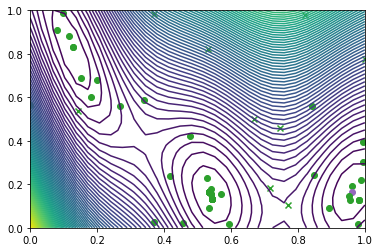

In [6]:
from util.plotting import plot_function_2d, plot_bo_points

arg_min_idx = tf.squeeze(tf.argmin(dataset.observations, axis=0))
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()
_, ax = plot_function_2d(
    branin,
    search_space.lower,
    search_space.upper,
    grid_density=30,
    contour=True,
)

plot_bo_points(query_points, ax[0, 0], num_initial_data_points, arg_min_idx)

We can also visualise the observations on a three-dimensional plot of the Branin. We'll add the contours of the mean and variance of the model's predictive distribution as translucent surfaces.

In [7]:
from util.plotting_plotly import (
    plot_model_predictions_plotly,
    add_bo_points_plotly,
)

fig = plot_model_predictions_plotly(
    result.try_get_final_model(),
    search_space.lower,
    search_space.upper,
)
fig = add_bo_points_plotly(
    x=query_points[:, 0],
    y=query_points[:, 1],
    z=observations[:, 0],
    num_init=num_initial_data_points,
    idx_best=arg_min_idx,
    fig=fig,
    figrow=1,
    figcol=1,
)
fig.show()

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)